# Importing Necessary Python Libraries

In [1]:
# Dataframe building and Analysis library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import random

# Word Stemming Library to make root words in a String
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Words to Vectors Library
from sklearn.feature_extraction.text import CountVectorizer

# Similarity and Distance Metrics Library
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.spatial import distance
from Levenshtein import distance as levenshtein_distance

# Data Extraction and Exploratory Analysis

In [13]:
# Dataset in two files (test and train) directly downloaded from Blob Storage in Azure Cloud
test = pd.read_csv(r'https://researchproject.blob.core.windows.net/project/drugsComTest_raw.csv', na_values=['(NA)']).fillna(0)
train = pd.read_csv(r'https://researchproject.blob.core.windows.net/project/drugsComTrain_raw.csv', na_values=['(NA)']).fillna(0)

In [14]:
df = pd.concat([test, train], ignore_index=True, sort=False)
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22,0,0,0,0,0,0
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17,0,0,0,0,0,0
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3,0,0,0,0,0,0
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,05-Mar-17,35,0,0,0,0,0,0
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4,0,0,0,0,0,0


In [15]:
#Dropping Unneccesary Columns
df = df.drop(columns=['date','Unnamed: 7', 'Unnamed: 8','Unnamed: 9','Unnamed: 10','Unnamed: 11','Unnamed: 12'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222272 entries, 0 to 222271
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     222272 non-null  object
 1   drugName     222272 non-null  object
 2   condition    222272 non-null  object
 3   review       222272 non-null  object
 4   rating       222272 non-null  object
 5   usefulCount  222272 non-null  object
dtypes: object(6)
memory usage: 10.2+ MB


In [16]:
# Converting 'Rating' and 'UsefulCount' into float type for generating new column of 'most_reviewed' drugs
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['usefulCount'] = pd.to_numeric(df['usefulCount'], errors='coerce')
df['most_reviewed'] = df['rating'] * df['usefulCount']

In [17]:
df = df[['uniqueID','drugName','condition','review','most_reviewed']]
df.head()

,uniqueID,drugName,condition,review,most_reviewed
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",220.0
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",136.0
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",27.0
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",315.0
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",36.0


# Plotting the graph for Top 10 Most Reviewed Drugs

In [18]:
#Sorting Top 10 Drugs in Dataset
df = df.sort_values(by='most_reviewed', ascending=False, ignore_index=True)
df = df.drop_duplicates(subset = ['condition'], ignore_index=True)
df = df.drop_duplicates(subset = ['drugName'], ignore_index=True)
df_graph = df[['drugName','most_reviewed']]
df_graph = df_graph.head(10)
df_graph

,drugName,most_reviewed
0,Sertraline,12910.0
1,Mirena,12470.0
2,Adipex-P,7960.0
3,Oxycodone,6255.0
4,Celexa,5544.0
5,BuSpar,5265.0
6,Clomid,4860.0
7,Topiramate,4670.0
8,Denosumab,4480.0
9,Amoxicillin,4080.0


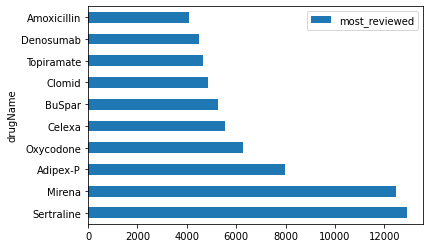

In [19]:
#MatplotLb Barh graph
df_graph.plot(kind='barh', x='drugName', y='most_reviewed')
plt.show()

In [20]:
#Removing unwanted characters and splitting in words the string value of 'Review' column
df['review'] = df['review'].map(lambda x: re.sub(r'["&#039;"]','', x))
df['review'] = df['review'].apply(lambda x: x.split())
df['review'].values

array([list(['I', 'remember', 'reading', 'peoples', 'opinions,', 'online,', 'of', 'the', 'drug', 'before', 'I', 'took', 'it', 'and', 'it', 'scared', 'me', 'away', 'from', 'it.', 'Then', 'I', 'finally', 'decided', 'to', 'give', 'it', 'a', 'try', 'and', 'it', 'has', 'been', 'the', 'best', 'choice', 'I', 'have', 'made.', 'I', 'have', 'been', 'on', 'it', 'for', 'over', '4', 'months', 'and', 'I', 'feel', 'great.', 'Im', 'on', '1mg', 'and', 'I', 'dont', 'have', 'any', 'side', 'effects.', 'When', 'I', 'first', 'started', 'I', 'did', 'notice', 'that', 'my', 'hands', 'would', 'tremble', 'but', 'then', 'it', 'subsided.', 'So', 'honestly,', 'dont', 'listen', 'to', 'all', 'the', 'negativity', 'because', 'what', 'doesnt', 'work', 'for', 'some', 'works', 'amazing', 'for', 'others.', 'So', 'go', 'based', 'on', 'youself', 'and', 'not', 'everyone', 'else.', 'It', 'may', 'be', 'a', 'blessing', 'in', 'diguise.', 'The', 'pill', 'is', 'not', 'meant', 'to', 'make', 'you', 'be', 'all', 'happy', 'go', 'lucky'

In [21]:
# Now Concatnating Drugs and Condition values with Reviews to build metadata of drugs
df['condition_list'] = df['condition'].apply(lambda x: x.split())
df['condition_list'] = df['condition'].apply(lambda x: "".join(x))
df['drugName_list'] = df['drugName'].apply(lambda x: x.split())
df['drugName_list'] = df['drugName'].apply(lambda x: "".join(x))

In [22]:
df['condition_list'] = df['condition'].apply(lambda x: x.split())
df['drugName_list'] = df['drugName'].apply(lambda x: x.split())

In [23]:
df['tags'] = df['drugName_list'] + df['condition_list'] + df['review']

In [24]:
df.head()

,uniqueID,drugName,condition,review,most_reviewed,condition_list,drugName_list,tags
0,96616,Sertraline,Depression,"[I, remember, reading, peoples, opinions,, onl...",12910.0,[Depression],[Sertraline],"[Sertraline, Depression, I, remember, reading,..."
1,182560,Mirena,Birth Control,"[I, have, had, my, IUD, for, over, a, year, no...",12470.0,"[Birth, Control]",[Mirena],"[Mirena, Birth, Control, I, have, had, my, IUD..."
2,52305,Adipex-P,Weight Loss,"[I, have, used, this, pill, off, and, on, for,...",7960.0,"[Weight, Loss]",[Adipex-P],"[Adipex-P, Weight, Loss, I, have, used, this, ..."
3,189774,Oxycodone,Pain,"[Ahhhh,, the, dreaded, drug...no, matter, what...",6255.0,[Pain],[Oxycodone],"[Oxycodone, Pain, Ahhhh,, the, dreaded, drug....."
4,89748,Celexa,Anxiety and Stress,"[I, work, for, a, large, Fire, Department., I,...",5544.0,"[Anxiety, and, Stress]",[Celexa],"[Celexa, Anxiety, and, Stress, I, work, for, a..."


In [125]:
#Creating New Dataframe with relevant columns for further analysis
new_df = df[['uniqueID','drugName','condition','tags']]
new_df

,uniqueID,drugName,condition,tags
0,96616,Sertraline,Depression,"[Sertraline, Depression, I, remember, reading,..."
1,182560,Mirena,Birth Control,"[Mirena, Birth, Control, I, have, had, my, IUD..."
2,52305,Adipex-P,Weight Loss,"[Adipex-P, Weight, Loss, I, have, used, this, ..."
3,189774,Oxycodone,Pain,"[Oxycodone, Pain, Ahhhh,, the, dreaded, drug....."
4,89748,Celexa,Anxiety and Stress,"[Celexa, Anxiety, and, Stress, I, work, for, a..."
...,...,...,...,...
602,176719,Fluorometholone,Steroid Responsive Inflammatory Conditions,"[Fluorometholone, Steroid, Responsive, Inflamm..."
603,124927,Allopurinol,Hyperuricemia Secondary to Chemotherapy,"[Allopurinol, Hyperuricemia, Secondary, to, Ch..."
604,119648,Coagulation factor ix,Hemophilia B,"[Coagulation, factor, ix, Hemophilia, B, I, ha..."
605,209809,Phosphorated carbohydrate solution,Nausea (phosphorated carbohydrate solution),"[Phosphorated, carbohydrate, solution, Nausea,..."


In [126]:
new_df['tags'] = new_df['tags'].apply(lambda x:" ".join(x))
new_df['tags'] = new_df['tags'].apply(lambda x: x.lower())

<ipython-input-126-496123bdea0d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x:" ".join(x))
<ipython-input-126-496123bdea0d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x: x.lower())


In [127]:
new_df['tags'][0]

'sertraline depression i remember reading peoples opinions, online, of the drug before i took it and it scared me away from it. then i finally decided to give it a try and it has been the best choice i have made. i have been on it for over 4 months and i feel great. im on 1mg and i dont have any side effects. when i first started i did notice that my hands would tremble but then it subsided. so honestly, dont listen to all the negativity because what doesnt work for some works amazing for others. so go based on youself and not everyone else. it may be a blessing in diguise. the pill is not meant to make you be all happy go lucky and see quotbutterflies and rosesquot, its meant to help put the chemicals in your mind in balance so you can just be who you are and not overly depressed. i still get sad some times, but that is normal, that is life, and its up to people to take control to make a change. i did so by getting on this pill.'

# Stemming using NLTK Library and comparing results 

In [128]:
# PorterStemmer is applied to check root words
ps = PorterStemmer()
def stem(text):
    y = []
    for i in text.split():
        y.append(ps.stem(i))
        
    return " ".join(y)

In [129]:
new_df_ps = new_df[['uniqueID','drugName','condition','tags']]
new_df_ps['tags'] = new_df_ps['tags'].apply(stem)
new_df_ps['tags'][0]

'sertralin depress i rememb read peopl opinions, online, of the drug befor i took it and it scare me away from it. then i final decid to give it a tri and it ha been the best choic i have made. i have been on it for over 4 month and i feel great. im on 1mg and i dont have ani side effects. when i first start i did notic that my hand would trembl but then it subsided. so honestly, dont listen to all the neg becaus what doesnt work for some work amaz for others. so go base on youself and not everyon else. it may be a bless in diguise. the pill is not meant to make you be all happi go lucki and see quotbutterfli and rosesquot, it meant to help put the chemic in your mind in balanc so you can just be who you are and not overli depressed. i still get sad some times, but that is normal, that is life, and it up to peopl to take control to make a change. i did so by get on thi pill.'

In [130]:
# WordNetLemmatizer is also deployed to check root words and meaning consistency
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemma(text):
    y = []
    for i in text.split():
        y.append(wordnet_lemmatizer.lemmatize(i, pos="v"))
        
    return " ".join(y)

In [131]:
new_df_lemma = new_df[['uniqueID','drugName','condition','tags']]
new_df_lemma['tags'] = new_df_lemma['tags'].apply(lemma)
new_df_lemma['tags'][0]

'sertraline depression i remember read people opinions, online, of the drug before i take it and it scar me away from it. then i finally decide to give it a try and it have be the best choice i have made. i have be on it for over 4 months and i feel great. im on 1mg and i dont have any side effects. when i first start i do notice that my hand would tremble but then it subsided. so honestly, dont listen to all the negativity because what doesnt work for some work amaze for others. so go base on youself and not everyone else. it may be a bless in diguise. the pill be not mean to make you be all happy go lucky and see quotbutterflies and rosesquot, its mean to help put the chemicals in your mind in balance so you can just be who you be and not overly depressed. i still get sad some times, but that be normal, that be life, and its up to people to take control to make a change. i do so by get on this pill.'

#  Implementing Count Vectorizer to make words in vector form

In [132]:
# Max Features is set to 500 a d stop words are removed from string
from sklearn.feature_extraction.text import CountVectorizer
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text
cv = CountVectorizer(max_features=500, stop_words='english', analyzer='word', preprocessor=preprocess_text)

In [133]:
# Applying Fit Transform to Lemma processed vector as it give more relevant meaning
vectors = cv.fit_transform(new_df_lemma['tags']).toarray()
vectors[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,

In [134]:
# Getting Top 500 most used words from bag of words of 'Tags' column values
cv.get_feature_names_out()

array(['able', 'absolutely', 'ache', 'acid', 'acne', 'active', 'actually',
       'acute', 'add', 'affect', 'afternoon', 'age', 'ago', 'alive',
       'allergic', 'allow', 'amaze', 'amazing', 'amp', 'anemia', 'anti',
       'antibiotic', 'antibiotics', 'anxiety', 'anymore', 'appetite',
       'apply', 'area', 'arthritis', 'associate', 'asthma', 'attack',
       'away', 'awesome', 'baby', 'bad', 'barely', 'bathroom', 'bed',
       'begin', 'believe', 'benefit', 'best', 'better', 'big', 'birth',
       'bite', 'bladder', 'bleed', 'blood', 'body', 'bone', 'bottle',
       'bowel', 'brain', 'brand', 'break', 'breast', 'breath', 'breathe',
       'burn', 'cance', 'cancer', 'care', 'case', 'cause', 'cell',
       'chance', 'change', 'chemo', 'chest', 'chronic', 'clear', 'close',
       'cold', 'combination', 'come', 'comment', 'complete', 'completely',
       'concern', 'condition', 'congestion', 'consider', 'constant',
       'constantly', 'constipation', 'continue', 'control', 'copd',
    

# Evaluating Model with Various Similarity and Distances Metrices

In [110]:
# Pearson Correlation with first drug and random drugs
l=[]
for i in random.sample(range(1, 600), 10):
    corr, _ = pearsonr(vectors[0],vectors[i])
    l.append(corr)
    print('Pearsons correlation: %.3f' % corr)
avg=np.mean(l)
print('Pearsons correlation average: %.3f' % avg)

Pearsons correlation: 0.160
Pearsons correlation: 0.063
Pearsons correlation: 0.065
Pearsons correlation: 0.065
Pearsons correlation: 0.064
Pearsons correlation: 0.158
Pearsons correlation: 0.107
Pearsons correlation: 0.033
Pearsons correlation: -0.023
Pearsons correlation: 0.051
Pearsons correlation average: 0.074


In [111]:
# Spearman Correlation with first drug and random drugs
l=[]
for i in random.sample(range(1, 600), 10):
    corr, _ = spearmanr(vectors[0],vectors[i])
    l.append(corr)
    print('Spearmans correlation: %.3f' % corr)
avg=np.mean(l)
print('Spearmans correlation average: %.3f' % avg)

Spearmans correlation: 0.070
Spearmans correlation: 0.027
Spearmans correlation: 0.082
Spearmans correlation: 0.120
Spearmans correlation: 0.171
Spearmans correlation: 0.017
Spearmans correlation: 0.088
Spearmans correlation: 0.053
Spearmans correlation: 0.045
Spearmans correlation: 0.056
Spearmans correlation average: 0.073


In [112]:
# Kendall Tau's correlation with first drug and random drugs
l=[]
for i in random.sample(range(1, 600), 10):
    corr, _ = kendalltau(vectors[0],vectors[i])
    l.append(corr)
    print('Kendalls tau: %.3f' % corr)
avg=np.mean(l)
print('Kendalls tau average: %.3f' % avg)

Kendalls tau: 0.094
Kendalls tau: 0.053
Kendalls tau: 0.113
Kendalls tau: 0.155
Kendalls tau: 0.037
Kendalls tau: 0.064
Kendalls tau: 0.185
Kendalls tau: 0.021
Kendalls tau: 0.110
Kendalls tau: 0.151
Kendalls tau average: 0.098


In [113]:
# Cosine Similarity with first drug and random drugs
l=[]
for i in random.sample(range(1, 600), 10):
    cos_sim = cosine_similarity(vectors[0].reshape(1,-1),vectors[i].reshape(1,-1))
    l.append(cos_sim)
    print('Cosine similarity: %.3f' % cos_sim)
avg=np.mean(l)
print('Cosine similarity average: %.3f' % avg)

Cosine similarity: 0.155
Cosine similarity: 0.198
Cosine similarity: 0.044
Cosine similarity: 0.162
Cosine similarity: 0.115
Cosine similarity: 0.048
Cosine similarity: 0.000
Cosine similarity: 0.121
Cosine similarity: 0.000
Cosine similarity: 0.136
Cosine similarity average: 0.098


In [114]:
# Jaccard's similarity among two first drug and random drugs
l=[]
for i in random.sample(range(1, 600), 10):
    jacc = jaccard_score(vectors[0],vectors[i], average='macro')
    l.append(jacc)
    print('Jaccard similarity: %.3f' % jacc)
avg=np.mean(l)
print('Jaccard similarity average: %.3f' % avg)

Jaccard similarity: 0.320
Jaccard similarity: 0.327
Jaccard similarity: 0.238
Jaccard similarity: 0.226
Jaccard similarity: 0.305
Jaccard similarity: 0.323
Jaccard similarity: 0.233
Jaccard similarity: 0.233
Jaccard similarity: 0.234
Jaccard similarity: 0.302
Jaccard similarity average: 0.274


In [115]:
#Euclidean Distance between two first drug and random drugs
for i in random.sample(range(1, 600), 10):
    dst = distance.euclidean(vectors[0],vectors[i])
    print('Euclidean distance: %.3f' % dst)

Euclidean distance: 8.944
Euclidean distance: 7.681
Euclidean distance: 7.211
Euclidean distance: 9.899
Euclidean distance: 8.246
Euclidean distance: 7.874
Euclidean distance: 7.550
Euclidean distance: 8.062
Euclidean distance: 7.211
Euclidean distance: 9.747


In [116]:
#Manhattan Distance between two first drug and random drugs
for i in random.sample(range(1, 600), 10):
    dst = distance.cityblock(vectors[0],vectors[i])
    print('Manhattan distance: %.3f' % dst)

Manhattan distance: 51.000
Manhattan distance: 82.000
Manhattan distance: 49.000
Manhattan distance: 60.000
Manhattan distance: 52.000
Manhattan distance: 45.000
Manhattan distance: 41.000
Manhattan distance: 51.000
Manhattan distance: 61.000
Manhattan distance: 56.000


# Building Recommender system

In [68]:
# Choosing Cosine Similarity for recommender system building
similarity = cosine_similarity(vectors)
similarity[0]

array([1.        , 0.14342743, 0.22883102, 0.23333333, 0.21320072,
       0.2032002 , 0.10504515, 0.        , 0.12344268, 0.15811388,
       0.20754981, 0.17253244, 0.22478059, 0.2857738 , 0.07745967,
       0.05080005, 0.08944272, 0.2       , 0.17149859, 0.21998878,
       0.13228757, 0.2502173 , 0.28879795, 0.25537696, 0.13719887,
       0.12377055, 0.02390457, 0.09701425, 0.02264554, 0.02      ,
       0.07022469, 0.24910095, 0.        , 0.05345225, 0.        ,
       0.13363062, 0.12247449, 0.05345225, 0.11313708, 0.21773242,
       0.08660254, 0.15491933, 0.02773501, 0.1165543 , 0.04780914,
       0.08834522, 0.10910895, 0.1963961 , 0.08944272, 0.10606602,
       0.12977714, 0.25976265, 0.14433757, 0.12649111, 0.08660254,
       0.11313708, 0.23249528, 0.05345225, 0.08528029, 0.06172134,
       0.23094011, 0.22156468, 0.08320503, 0.12060454, 0.21380899,
       0.05080005, 0.04082483, 0.12247449, 0.40824829, 0.1767767 ,
       0.1       , 0.14485719, 0.15118579, 0.14770979, 0.06188

In [118]:
# Sorting similarity in descending orders to make more similar drugs on top.
sorted((list(enumerate(similarity[2]))), reverse=True, key=lambda x:x[1])[0:11]

[(2, 1.0),
 (45, 0.40011084938552827),
 (254, 0.37121293493384755),
 (12, 0.33933982252531925),
 (176, 0.3252462512726967),
 (145, 0.3057883148625753),
 (300, 0.30046985150168065),
 (164, 0.27782541996623855),
 (391, 0.27623182989113954),
 (315, 0.2754306972098739),
 (177, 0.27307227890281793)]

In [138]:
#Defing a function to recommend drug based on condition selected
def recommend(condition):
    drug_index = new_df_lemma[new_df_lemma['condition'] == condition].index[0]
    distances = similarity[drug_index]
    drug_list = sorted((list(enumerate(distances))), reverse=True, key=lambda x:x[1])[0:5]
    for i in drug_list:
        print(new_df_lemma.iloc[i[0]].drugName)

In [139]:
# Testing the Recommender system
recommend('Varicose Veins')

Horse chestnut
Lidocaine
Pregabalin
Multivitamin
Turmeric


In [141]:
# PKL files are imported for deploying the application into Heroku Cloud App
pickle.dump(new_df_lemma.to_dict(), open('drugs_dict.pkl','wb'))
pickle.dump(similarity,open('similarity.pkl','wb'))